# Sparse reconstruction with Julia

## Context

This notebook is a small example of sparse reconstruction with Julia, done in Master 1 under the supervision of Simon Ehouarn in Master 1.

## General framework

The aim of this tutorial is to show that standard optimization techniques can be used to recover signals that admit a parsimonious representation in a certain base, i.e. involving a small number of coefficients.

## Problem I

We are interested in the reconstruction of a vector $x$ (here a greyscale image) using the values of random combinations of certain pixels. The combinations are represented by a $\Phi$ matrix.

A first approach consists in solving the problem

$$
\min_x \frac{1}{2} ||\Phi x-y||_2^2
$$


### Import the packages and the data

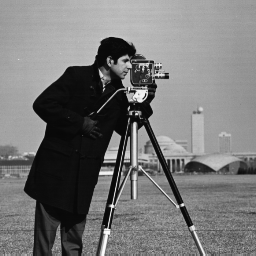

In [19]:
#
# Uncomment to install the required packages:
#
# import Pkg
# Pkg.add("Images")
# Pkg.add("ImageMagick")
# Pkg.add("FFTW")
# Pkg.add("Colors")

#
# Importing the required packages:
#
using Images, Colors, LinearAlgebra, FFTW


img1 = load("cameraman.tif");
img = convert(Array{Gray},img1);
# A = float(convert(Array,img));
A = convert(Array{Float64},img);

tmp = @view img1[:,:]

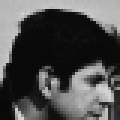

In [20]:
# Extraction of a contrasted sub-image
k    = 40;
orig = 35;
Aloc = A[orig:orig+k-1,orig+60:orig+60+k-1];
x   = (Aloc[:]);
n   = length(x);
m   = 500; 
Phi = randn(m,n);

imhsv = colorview(Gray,float(Aloc));
tmp = @view imhsv[:,:]

### Resolution

#### Naive approach

As announced, a first approach consists in solving the problem
$$
\min_x || \Phi x -y ||_2
$$

We obtain the solution of the problem by solving the normal equations :
$$
\Phi^T\Phi x^* = \Phi^T y
$$
or by computing the pseudo-inverse of $\Phi$, which we note $\Phi^+$. It follows that $x^* = \Phi^+ y$.

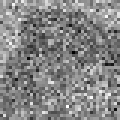

In [23]:
y = Phi*x ; # "Observations" vector of the image

# Method 1
##########

tPhi = transpose(Phi)
PhiPhiT = Phi*tPhi
pseudo_inv_Phi = tPhi*inv(PhiPhiT) # one could also use pseudo_inv_Phi = pinv(Phi)
x_star1 = pseudo_inv_Phi*y
im_star1 = reshape(x_star1,(k,k))

# Rescaling :
im_star1 = 1/(maximum(im_star1).-minimum(im_star1))*(im_star1.-minimum(im_star1));

# Plot
imhsv = colorview(Gray, float(im_star1));
tmp=@view imhsv[:,:]

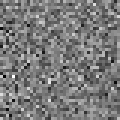

In [24]:
# Method 2: another option is to use a backslash rather than to compute the pseudo-inverse by hand
##########

tPhi = transpose(Phi)
PhiTPhi = tPhi*Phi
x_star2 = PhiTPhi\(tPhi*y)
im_star2 = reshape(x_star2,(k,k))

# Rescaling :
im_star2 = 1/(maximum(im_star2).-minimum(im_star2))*(im_star2.-minimum(im_star2));

# Plot
imhsv = colorview(Gray, float(im_star2));
tmp=@view imhsv[:,:]

In any case, we see that the solution is not good. This is due to the fact that the matrix $\Phi$ is not full rank.

Moreover, it is even worse if we use the wrapper "\\" : the solver stops before converging, and we cannot force it to do more iterations.

#### Compressive sensing

Now we want to use the discrete cosine transform to obtain a sparse representation of an image. This bijective transformation is obtained with the function `dct`, its inverse being `idct`. Using the `idct` function of Julia, we compute the matrix $\Theta = \Phi*\Psi$, with $\Psi$ the matrix representing IDCT in the canonical basis.

In [26]:
Theta = zeros(m,n);
for ii = 1:n
    ek = zeros(1,n);
    ek[ii] = 1;
    psi = idct(ek)';
    Theta[:,ii] = Phi*psi;
end

##### With a sub-gradient method

Let $\lambda > 0$ be a regularization parameter, we compute $x_{sg}= \Psi z$ where $z$ solves

$$
\min_z f(z) \overset{\Delta}{=} \frac{1}{2} ||\Phi  \cdot \Psi  \cdot z -y||_2^2+ \lambda ||z||_1.
$$

We use the sub-gradient method to solve this problem. We note $z_k$ the iterate at the $k$-th iteration. We have

$$
z_{k+1} = z_k - \frac{1}{\alpha_k} \tilde\nabla f(z_k)
$$

where $\alpha_k$ is a step-size, $f$ is the objective function, and $\tilde\nabla$ denotes any subgradient. We actually have, denoting by $\text{sign}(z)$ is the vector whose $i$-th component is the sign of the $i$-th component of $z$:

$$
\tilde\nabla f(z) = \Phi^T \Phi \Psi z - \Phi^T y + \lambda\, \text{sign}(z)
$$

yielding:

$$
z_{i+1} = z_i - \frac{1}{\alpha_i} (\Phi^T \Phi \Psi z_i - \Phi^T y + \lambda \text{sign}(z_i))
$$

The advantage of this method is that it ensures the sparsity of the solution. However, it is not guaranteed that the solution z verifies $\Phi\Psi z = y$. To guarantee this, see the following section.


In [33]:
z = zeros(k^2,1); i=0; lambda=1e-2;
choix_pas = 3; # see below
while i <= 1000
    i = i + 1; 
    
    gk = (1/2)*transpose(Theta)*(Theta*z-y)+lambda*sign.(z)
    if choix_pas == 1
        z -= 1e-4*gk
    elseif choix_pas == 2
        z -= 1/(100i) * gk
    elseif choix_pas == 3
        z -= 1/(100sqrt(i)) * gk
    end
end
norm(Theta\y)

9.505024096643453

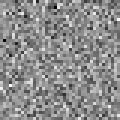

In [34]:
function apply_psi(n,k,z)
    x2 = zeros(n,1);
    for ii = 1:n
        ii
        ek = zeros(1,n);
        ek[ii] = 1;
        psi = idct(ek)';
        x2 = x2+psi*z[ii];
    end
    x2 = reshape(x2,k,k);
    x2 = 1/(maximum(x2).-minimum(x2))*(x2.-minimum(x2));
    return x2
end

x2 = apply_psi(n,k,z);
imhsv = colorview(Gray, float(x2));
tmp=@view imhsv[:,:]

This is still not a good solution. In the next section, we will use the projected gradient method to guarantee that the solution verifies $\Phi\Psi z = y$.

##### With a projected gradient method

We now want to compute $x_{sgp}= \Psi z$ where $z$ solves the problem
$$
\min_{\Phi  \cdot \Psi  \cdot z =y}  ||z||_1
$$

In such a case, we have that $\Phi\Psi z = y$. Thus, z solution of this problem is the smallest z (in norm 1) such that $\Phi\Psi z = y$.

Let us note $\mathcal{C} = \{x, \Phi  \cdot \Psi  \cdot z =y \}$. We recall that the projection on $\mathcal{C}$ is defined by : $\forall x\in \mathbf{R}^n, \quad \Pi_\mathcal{C}(x) = \underset{u\in\mathcal{C}}{\mathrm{argmin}}||u-x||$.

In [36]:
z = zeros(k^2,1); 
i=0;
choix_pas = 3; # see below

z = Theta\y

pinvA = pinv(Theta)
projecteur = pinvA*Theta

while i <= 1000
    i = i + 1; 
    gk = sign.(z)
    
    if choix_pas == 1
        z = z - 1e-4*(gk - projecteur*gk)
        
    elseif choix_pas == 2
        z = z - 1/(100i)*(gk - projecteur*gk)
    elseif choix_pas == 3
        z = z - 1/(norm(gk)*sqrt(i))*(gk - projecteur*gk)
    end
end

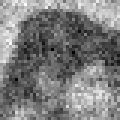

In [37]:
x3 = apply_psi(n,k,z);
imhsv = colorview(Gray,float(x3));
tmp = @view imhsv[:,:]

This is undoubtedly better with the projected gradient method.

## Problem II
We are interested in the problem

$$
\hspace{5cm} (\mathcal{P})\quad \min_{x\in \mathbb{R}^n}f(x) = \frac{1}{2}\Vert H x-y \Vert_W^2+\lambda \Vert x \Vert_1
$$

with $y\in \mathbb{R}^m$ an observation of the signal to reconstruct, $H\in \mathcal{M}_{m,n}(\mathbb{R})$, $W\in \mathcal{M}_{m}(\mathbb{R})$ symmetric positive definite. The matrix $W$ introduces a weighting on the components of the residual.

If necessary, the problem can be rewritten:

$$
\hspace{5cm} (\mathcal{P})\quad \min_{x\in \mathbb{R}^n}f(x) = \frac{1}{2} \langle H x-y, W(H x-y) \rangle+\lambda \Vert x \Vert_1
$$

The functional is differentiable, so the subdifferential is simply $\{ \nabla f(x) \}$, and we have : $\nabla f(x) = H^TW \left(Hx-y\right) + \lambda\, \mathrm{sign}(x)$.

### Import the packages

In [62]:
using LinearAlgebra
# using Pkg
# Pkg.add("Plots") # uncomment (along with above line) if you don't have the package
using Plots
# Pkg.add("ORCA")
using ORCA

### Construction of the data

In [63]:
# Building the problem #
########################

# solution
##########
dx = 0.01;
n = Int(1/dx);
px = LinRange(0.,1.,n);
xt = zeros(n,1);

for i = 1:n
    if (px[i] > 0.3 && px[i]< 0.6)
        xt[i] = 2;         
    end
end

# observations
##############
nobs = 1;
m = Int(floor(n/nobs));
var_obs = 0.05;
sigmaW = ones(m,1)+2.0*rand(Float64,(m,1));

H = zeros(m,n);
py = zeros(m,1);
W = zeros(m,m);
for i=1:m
   H[i,(i-1)*nobs+1] = 1;
   py[i] = px[(i-1)*nobs+1]; 
   W[i,i] = sigmaW[i];
end    
y = H*xt+var_obs*randn(Float64,(m,1));


p1 = plot(px,xt,title="True solution",label=["xt"],lw=3);
p2 = scatter(py,y,title="Observations",lw=3);
plot(p1,p2,layout=(1,2),legend=false)

### Subgradient algorithm

In [64]:
# Function evaluating f at x
function evalf(x,y,H,W,lambda)
    u = H*x-y
    return (1/2)*(transpose(u)*W*u)[1] + lambda*norm(x,1)
end

# Function evaluating a subgradient of f at x
function subgradf(x,y,H,W,lambda) 
    return transpose(H)*W*(H*x-y)+lambda*sign.(x)
end

subgradf (generic function with 1 method)

#### Easiest algorithm

##### Implementation

In [72]:
function subgradient_simple(x,y,H,W,lambda,pas,itermax_subgradient_simple)
    xp = x;
    xbest = xp;
    fbest = 1000000; # $f_{best}^0$
    histo_subgradient_simple = []; # Sequence of iterates f_{best}^k
    i = 0;
    while i < itermax_subgradient_simple
        i = i + 1;
        gk = subgradf(x,y,H,W,lambda)
        if pas == 1
            xp -= 1e-2*gk
        elseif pas == 2
            xp -= 1/(100i) * gk
        elseif pas == 3
            xp -= 1/(norm(gk)*sqrt(i)) * gk
        end

        if evalf(xp,y,H,W,lambda) < fbest
            fbest = evalf(xp,y,H,W,lambda)
            xbest = xp
        end

        # Stockage
        append!( histo_subgradient_simple, fbest)
    end
    return xbest, histo_subgradient_simple
end

subgradient_simple (generic function with 1 method)

##### Results

We test the algorithm with different initialisation values. We will interpret the results in the next section.

In [73]:
# Initialization
x = zeros(n,1);
lambda=1e-2;
itermax_subgradient_simple=100;
pas = 1
xbest, histo_subgradient_simple = subgradient_simple(x,y,H,W,lambda,pas,itermax_subgradient_simple);
plotly();

iter_subgradient_simple = 1:itermax_subgradient_simple;
x = [xt,xbest];

p1 = plot(iter_subgradient_simple,histo_subgradient_simple,title="Convergence curve",label=["f"],lw=3,ann=[(55,80,"Simple sub-gradient")])
p2 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)
plot(p1,p2,layout=(1,2),legend=false)

In [70]:
#Initialisation
x = 100*ones(n,1);
lambda=1e-2;
itermax_subgradient_simple=100;
pas = 1
xbest, histo_subgradient_simple = subgradient_simple(x,y,H,W,lambda,pas,itermax_subgradient_simple);
plotly();

iter_subgradient_simple = 1:itermax_subgradient_simple;
x = [xt,xbest];

p7 = plot(iter_subgradient_simple,histo_subgradient_simple,title="Convergence curve",label=["f"],lw=3,ann=[(55,80,"Simple sub-gradient")])
p8 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

In [71]:
#Initialisation
x = ones(n,1);
lambda=1e-2;
itermax_subgradient_simple=100;
pas = 1
xbest, histo_subgradient_simple = subgradient_simple(x,y,H,W,lambda,pas,itermax_subgradient_simple);
plotly();

iter_subgradient_simple = 1:itermax_subgradient_simple;
x = [xt,xbest];

p7 = plot(iter_subgradient_simple,histo_subgradient_simple,title="Convergence curve",label=["f"],lw=3,ann=[(55,80,"Simple sub-gradient")])
p8 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

p13 = plot(iter_subgradient_simple,histo_subgradient_simple,title="Convergence curve",label=["f"],lw=3,ann=[(55,60,"Sous-gradient simple")])
p14 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

#### Proximal gradient algorithm

Now let $h(x)=\lambda \Vert x\Vert_1$ and $g(x)=\frac{1}{2}\Vert Hx-y\Vert_W^2$. 

The proximal operator of $h$ is defined by:
$$
\forall x\in\mathbb{R}^n, \quad \mathrm{prox}_h = \underset{u\in\mathbb{R}^n}{\mathrm{argmin}}\left(h(u)+\Vert u-x \Vert_2^2\right)
$$

##### Implementation

Let us implement it, along with $g$ and $\nabla g$:

In [81]:
# Evaluation of prox_h
function proxh(x,lambda)
        proxh = similar(x)
        n = length(x)

        # We should find a way to do this in vectorial but the following does not work
        #proxh = zeros(n) + (x-1*lambda*ones(n))*(x.>lambda) + (x+lambda*ones(n))*(x.<lambda)
        
        # Iterative version:
        for i in 1:n
            if x[i]>lambda
                proxh[i] = x[i]-lambda
            elseif x[i]<lambda
                proxh[i] = x[i]+lambda
            else
                proxh[i] = 0
            end
        end
        
        return proxh
    end
    
    #Evaluation of g
    function evalg(x,y,H,W)
        u = H*x-y
        (1/2)*(transpose(u)*W*u)[1]
    end    
    
    # Evaluation of the gradient of g
    function gradg(x,y,H,W)
        return transpose(H)*W*(H*x-y)
    end    

gradg (generic function with 1 method)

Let us also implement a line-search algorithm, which will be used in the proximal gradient method.

In [82]:
function search_step(alpha0,x,y,H,W,beta,lambda)
    alpha = alpha0
    gx = gradg(x,y,H,W)
    Gak = (1/alpha)*(x-proxh(x-alpha*gx,alpha*lambda))
    while evalg(x-alpha*Gak,y,H,W) > evalg(x,y,H,W)-alpha*(transpose(gx)*Gak)[1]+(alpha/2)*norm(Gak,2)^2
        alpha *= beta
        Gak = (1/alpha)*(x-proxh(x-alpha*gx,alpha*lambda))
    end
    return alpha
end

search_step (generic function with 1 method)

In [83]:
function grad_prox(x,y,H,W,lambda0,itermax_grad_prox,alpha0,beta)
    #Initialisation
    xbest = x;
    i = 0;
    fbest = 1000000;
    histo_grad_prox = [];

    xp = x;
    ap = alpha0;

    while i < itermax_grad_prox
        i = i + 1;
        ap = search_step(ap,xp,y,H,W,beta,lambda0)
        xp = proxh(xp-ap*gradg(xp,y,H,W),ap*lambda0)

        if evalf(xp,y,H,W,lambda0) < fbest
            fbest = evalf(xp,y,H,W,lambda0)
            xbest = xp
        end

        # Stockage
        append!( histo_grad_prox, fbest)
    end
    return xbest, histo_grad_prox
end

grad_prox (generic function with 1 method)

##### Results

In [87]:
#Initialisation
x = zeros(n,1);
lambda0 = 1e-2;
itermax_grad_prox = 10;
alpha0 = 1
beta = 0.5;

xbest, histo_grad_prox = grad_prox(x,y,H,W,lambda0,itermax_grad_prox,alpha0,beta);
plotly();
iter_grad_prox = 1:itermax_grad_prox;
x = [xt,xbest];

p3 = plot(iter_grad_prox,histo_grad_prox,title="Convergence curve",label=["f"],lw=3, ann=[(6,20,"Gradient proximal")])
p4 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)
plot(p3,p4,layout=(1,2),legend=false)

In [90]:
#Initialisation
x = 100*ones(n,1);
lambda0 = 1e-2;
itermax_grad_prox = 10;
alpha0 = 1
beta = 0.5;

xbest, histo_grad_prox = grad_prox(x,y,H,W,lambda0,itermax_grad_prox,alpha0,beta);
plotly();
iter_grad_prox = 1:itermax_grad_prox;
x = [xt,xbest];

p9 = plot(iter_grad_prox,histo_grad_prox,title="Convergence curve",label=["f"],lw=3, ann=[(6,20,"Gradient proximal")])
p10 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

In [91]:
#Initialisation
x = ones(n,1);
lambda0 = 1e-2;
itermax_grad_prox = 10;
alpha0 = 1
beta = 0.5;

xbest, histo_grad_prox = grad_prox(x,y,H,W,lambda0,itermax_grad_prox,alpha0,beta);
plotly();
iter_grad_prox = 1:itermax_grad_prox;
x = [xt,xbest];

p15 = plot(iter_grad_prox,histo_grad_prox,title="Convergence curve",label=["f"],lw=3, ann=[(6,20,"Gradient proximal")])
p16 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

#### FISTA algorithm

In [95]:
function FISTA(x,y,H,W,lambda0,itermax_FISTA,alpha0,beta)
    #Initialisation
    xbest=x;
    i = 0;
    fbest =1000000; # $f_{best}^0$
    histo_FISTA =[];# Suite des itérés f_{best}^k 

    xp=x;
    zp=x;
    ap=alpha0;

    while i < itermax_FISTA
        i = i + 1;
        # Insérer votre code
        ap = search_step(ap,zp,y,H,W,beta,lambda0)
        xprev = xp
        xp = proxh(zp-ap*gradg(zp,y,H,W),ap*lambda0)
        zp = xp + ((i-1)/(i+2))*(xp-xprev)

        if evalf(xp,y,H,W,lambda0) < fbest
            fbest = evalf(xp,y,H,W,lambda0)
            xbest = xp
        end

        # Fin insérer code

        # Stockage
        append!( histo_FISTA, fbest)
    end
    return xbest, histo_FISTA
end

FISTA (generic function with 1 method)

##### Results

In [96]:
#Initialisation
x = zeros(n,1);
lambda0 = 1e-2;
itermax_FISTA = 10;
alpha0 = 1
beta = 0.5;

xbest, histo_FISTA = FISTA(x,y,H,W,lambda0,itermax_FISTA,alpha0,beta);
plotly();

iter_FISTA = 1:itermax_FISTA;
x = [xt,xbest];

p5 = plot(iter_FISTA,histo_FISTA,title="Convergence curve",label=["f"],lw=3, ann=[(6,20,"FISTA")])
p6 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

plot(p5,p6,layout=(1,2),legend=false)

In [97]:
#Initialisation
x = 100*ones(n,1);
lambda0 = 1e-2;
itermax_FISTA = 10;
alpha0 = 1
beta = 0.5;

xbest, histo_FISTA = FISTA(x,y,H,W,lambda0,itermax_FISTA,alpha0,beta);
plotly();

iter_FISTA = 1:itermax_FISTA;
x = [xt,xbest];

p11 = plot(iter_FISTA,histo_FISTA,title="Convergence curve",label=["f"],lw=3, ann=[(6,20,"FISTA")])
p12 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

In [98]:
#Initialisation
x = ones(n,1);
lambda0 = 1e-2;
itermax_FISTA = 10;
alpha0 = 1
beta = 0.5;

xbest, histo_FISTA = FISTA(x,y,H,W,lambda0,itermax_FISTA,alpha0,beta);
plotly();

iter_FISTA = 1:itermax_FISTA;
x = [xt,xbest];

p17 = plot(iter_FISTA,histo_FISTA,title="Convergence curve",label=["f"],lw=3, ann=[(6,20,"FISTA")])
p18 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

### Comparison of the different algorithms

#### $\lambda=10^{-2}$, $\alpha_0=1$, $\beta=0.5$, x = `zeros(n,1)`

In [99]:
plot(p1,p2,p3,p4,p5,p6,layout=(3,2),legend=false)

#### $\lambda=10^{-2}$, $\alpha_0=1$, $\beta=0.5$, x = `ones(n,1)`

In [100]:
plot(p13,p14,p15,p16,p17,p18,layout=(3,2),legend=false,title="")

#### $\lambda=10^{-2}$, $\alpha_0=1$, $\beta=0.5$, x = `100*ones(n,1)`

In [101]:
plot(p7,p8,p9,p10,p11,p12,layout=(3,2),legend=false,title="")